Importing the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist


Using TensorFlow backend.


## Preprocessing
Loading the MNIST dataset and performing the required preprocessing on the data. Reshaping the training data and testing data such that all the images are flattened into column and each column of the dataset X represents one training example. Additionally, normalizing the training and testing data by dividing each pixel value in the dataset by 255.  Reshaping the training and testing label to a row vector. The last digit of my student ID = 0, thus modifying the labels of the training and testing data to contain value 1 for an image containing the number 0 and a value of 0 otherwise. Additionally, printing the shapes of the training and testing data and labels to confirm correct preprocessing.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('The training set contains: ', len(x_train))
print('test set: ', len(x_test))
print('Shape of the training data',x_train.shape)
print('shape of training label',y_train.shape)
# Performing the preprocessing steps on the data set
# Reshaping the training and test set such that each column represents an image
# Reshaping the training and test labels into row vectors
x_train = np.reshape(x_train, (60000, -1))
x_train = x_train.T
y_train = np.reshape(y_train, (1, -1))
x_test = np.reshape(x_test, (10000, -1))
x_test = x_test.T
y_test = np.reshape(y_test, (1, -1))
# Normalizing the data in training and test sets
x_train = x_train/255
x_test = x_test/255
# Updating the labels in the training and test set
# Last digit of my student id = 0
# Thus, the label of an image of number 0 should be 1 and 0 otherwise
# This is achieved by creating masks for the training and testing labels such that the masks have True for indices
# which correspond to an image of number 0
id_mask_train = y_train == 0
id_mask_test = y_test == 0
y_train[id_mask_train] = 1
y_train[np.logical_not(id_mask_train)] = 0
y_test[id_mask_test] = 1
y_test[np.logical_not(id_mask_test)] = 0
# Checking the shape of the training and test sets
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

The training set contains:  60000
test set:  10000
Shape of the training data (60000, 28, 28)
shape of training label (60000,)
(784, 60000)
(784, 10000)
(1, 60000)
(1, 10000)


## Deep Neural Network Class
Class for creating and training the neural network with 1 hidden layer to solve the Binary Classification problem on the MNIST dataset. The constructor method (_init_) loads the training and the test dataset, splits the training set into training (48000) + validation set(12000). The validation set is later used to tune the hyperparameters like the learning rate, the number of neurons in the hidden layer, the activation function for the hidden layer etc. 

### Activation Functions and their Gradients
Functions for implementing the sigmoid activation, tanh activation and ReLU activation functions. The function act_gradient computes and returns the gradeint of the activation function (provided as parameter). 

### Forward Propagation
The method forwardProp() performs the forward propagation through one layer of the neural network. The parameters provided to the method are : the weights and the biases associated with the layer, input to the layer and the activation function of the layer. It returns the output form the layer. 

### Backward Propagation
The method BackProp() performs the backward propagation through all the layers of the model to determine the gradients with respect to the weights and the biases of each layer

### Initialization
The method initialization initializes the weights and biases for the all layers of the model, small random values of the required dimensions using the numpy method random.random(). The random values (between 0 and 1) are multiplied by 0.01 to make them small. The number of neurons and the activation function for the hidden layer of the network is also loaded in the constructor method.

### Train Model
The method train_model() performs the gradeint descent algorithm for the training dataset, performs the forward propagation with the learned parameters to generate the predicted values for training set and computes the cost and accuracy achieved by the trained model on the training data. If multiple learning rates are provided to the object, then train_model() performs training with each learning rate, computes the cost of the learned model on the validation set and selects the value of alpha which performs best on the validation set for the final training of the model. The accuracy is computed by rounding the predicted values. These rounded prediction values are compared with ground truth values to comput the accuracy on the training data.

### MiniBatch SGD
The method miniBatchSGD() performs the mini batch gradeint descent algorithm for the training dataset, performs the forward propagation with the learned parameters to generate the predicted values for training set and computes the cost and accuracy achieved by the trained model on the training data. The number of epochs is provided as a parameter to the method. The accuracy is computed by rounding the predicted values. These rounded prediction values are compared with ground truth values to comput the accuracy on the training data.

### MiniBatch SGD with Momentum
The method MiniBatchSGD_Momentum() performs the mini batch gradeint descent with momentum algorithm for the training dataset, performs the forward propagation with the learned parameters to generate the predicted values for training set and computes the cost and accuracy achieved by the trained model on the training data. The number of epochs is provided as a parameter to the method. The accuracy is computed by rounding the predicted values. These rounded prediction values are compared with ground truth values to comput the accuracy on the training data.

### Test Model
The method test_model assess the trained model on the test data set. It performs the forward propagation with the learned parameters to generate the predicted values for the test set and computes the cost and accuracy achieved by the trained model on the test dataset. The accuracy is computed by rounding the predicted values. These rounded prediction values are compared with ground truth values to comput the accuracy on the test data.

### Validate Model
The method Validate_model asses the trained model on the validation set to tune the hyper parameters of the model.


In [7]:
class DeepNeuralNetwork:
    def __init__(self, x_train, y_train, x_test, y_test, alpha, layers=2, neurons=(8, 1),
                 activations=('ReLU', 'sigmoid'), val=False, reg=False, lmbda=0, drop=False, kp=1, 
                 batchSize = 64, beta = 0.9):
        if val:
            split = int(0.8*x_train.shape[1])
            self.x_val = x_train[:, split:]
            self.y_val = y_train[:, split:]
            
        else:
            split = x_train.shape[1]
            self.x_val = None
            self.y_val = None
        self.val = val
        self.x_train = x_train[:, :split]
        self.y_train = y_train[:, :split]
        self.x_test = x_test
        self.y_test = y_test
        self.alpha = alpha
        self.neurons = neurons
        self.W = None
        self.b = None
#         self.Z = None
#         self.A = None
        self.activations = activations
        self.layers = layers
        self.m = self.x_train.shape[1]
        self.reg = reg
        self. lmbda = lmbda
        self.drop = drop
        self.kp = kp
        self.batchSize = batchSize
        self.beta = beta
        
    
    
    def act_sigmoid(self, z):
        A = 1/(1+np.exp(-z))
        return A


    def act_tanh(self, z):
        A = np.tanh(z)
        return A


    def act_relu(self, z):
        A = np.maximum(0, z)
        return A
    
    
    def Activation_function(self, z, act):
        if act == 'ReLU':
            A = self.act_relu(z)
        elif act == 'tanh':
            A = self.act_tanh(z)
        elif act == 'sigmoid':
            A = self.act_sigmoid(z)
        return A

    
    def act_gradient(self, A, act = 'ReLU'):
        dg = np.zeros_like(A)
        if act == 'ReLU':
            dg[A>0] = 1
        elif act == 'sigmoid':
            dg = A*(1 - A)
        elif act == 'tanh':
            dg = 1 - np.square(A)

        return dg
    
    
    def initialization(self):
        W = []
        b = []
        V_W = []
        V_b = []
        n = self.x_train.shape[0]
        for i in range(self.layers):
            w = np.random.randn(self.neurons[i], n) / n**0.5 # *0.01
#             bias = np.random.randn(self.neurons[i], 1)* 0.1
            v_w = np.zeros((self.neurons[i], n))
            bias = np.zeros((self.neurons[i], 1))
            v_b = np.zeros((self.neurons[i], 1))
#             w = np.random.random((self.neurons[i], n))*0.01
#             bias = np.random.random((self.neurons[i], 1)) * 0.01
            W.append(w)
            b.append(bias)
            V_W.append(v_w)
            V_b.append(v_b)
#             print('bias[{}] = '.format(i), bias)
            n = self.neurons[i]
        self.W = W
        self.b = b
        self.V_W = V_W
        self.V_b = V_b
    
    
    def ForwardProp(self, x):#(self, x, y)
        Z = []
        A = []
        a = x
        # activation of the 0th layer is the training example
        # z of 1st layer is at Z[0]
        # activation of 1st layer is at A[1]
        A.append(a)
        for i in range(self.layers):
            z_l = np.dot(self.W[i], a) + self.b[i]
            a_l = self.Activation_function(z_l, self.activations[i])
            Z.append(z_l)
            A.append(a_l)
            a = a_l
#         self.Z = Z
#         self.A = A
        return Z, A
    
    def ForwardProp_Drop(self, x):  # (self, x, y)
        Z = []
        A = []
        D = []
        a = x
        # activation of the 0th layer is the training example
        # z of 1st layer is at Z[0]
        # activation of 1st layer is at A[1]
        A.append(a)
        for i in range(self.layers):
            z_l = np.dot(self.W[i], a) + self.b[i]
            a_l = self.Activation_function(z_l, self.activations[i])
            if i != self.layers - 1:
                d_l = np.random.randn(a_l.shape[0], a_l.shape[1])
                d_l = (d_l<self.kp)
                a_l = a_l * d_l
                a_l = a_l/self.kp
                D.append(d_l)
            Z.append(z_l)
            A.append(a_l)

            a = a_l
        #         self.Z = Z
        #         self.A = A
        return Z, A, D
    
    def BackProp(self, Z, A, y, m):
#         dA = - self.y_train/A[-1] + (1 - self.y_train)/(1 - A[-1])
        dZ = Z.copy()
        dW = self.W.copy()
        db = self.b.copy()
        a = A[-1]
        dZ[-1] = A[-1] - y
        for i in range(len(dZ) - 1, -1, -1):
#             dZ[i] = dA*self.act_gradient(a, self.activations[i])
            dW[i] = dZ[i].dot(A[i].T) / m
            if self.reg:
                dW[i] += self.lmbda*self.W[i] / m
            db[i] = np.sum(dZ[i], axis = 1) / m
            db[i] = np.reshape(db[i], (-1, 1))
#             print('Shape of db[{}] = '.format(i),db[i].shape)
            dA = np.dot(self.W[i].T, dZ[i])
            a = A[i]
            if i != 0:
                dZ[i - 1] = dA*self.act_gradient(a, self.activations[i - 1])
            
        return dW, db
    
    def BackProp_Drop(self, Z, A, D, y, m):
        #         dA = - self.y_train/A[-1] + (1 - self.y_train)/(1 - A[-1])
        dZ = Z.copy()
        dW = self.W.copy()
        db = self.b.copy()
        a = A[-1]
        dZ[-1] = A[-1] - y
        for i in range(len(dZ) - 1, -1, -1):
            #             dZ[i] = dA*self.act_gradient(a, self.activations[i])
            dW[i] = dZ[i].dot(A[i].T) / m
            if self.reg:
                dW[i] += self.lmbda * self.W[i] / m
            db[i] = np.sum(dZ[i], axis=1) / m
            db[i] = np.reshape(db[i], (-1, 1))
            #             print('Shape of db[{}] = '.format(i),db[i].shape)
            dA = np.dot(self.W[i].T, dZ[i])
            a = A[i]
            if i != 0:
                dZ[i - 1] = dA * self.act_gradient(a, self.activations[i - 1])
                dA = dA*D[i-1]
                dA = dA / self.kp
        return dW, db
    
    def miniBatchSGD(self, epochs):
        self.initialization()
        costs = []
        i = 0
        for epoch in range(epochs):
            indices = np.random.permutation(self.m)
            X = self.x_train[:, indices]
            Y = self.y_train[:, indices]
            if i == 0:
                print('shape of x_train: ', self.x_train.shape, 'shape of new X: ', X.shape)
                print('shape of y_train: ', self.y_train.shape, 'shape of new Y: ', Y.shape)
                i+=1
            split_indices = [i*self.batchSize for i in range(1, (self.m+self.batchSize - 1)//self.batchSize)]
            X_batches = np.split(X, split_indices, axis = 1)
            Y_batches = np.split(Y, split_indices, axis = 1)
            for ind, x_batch in enumerate(X_batches):
                if self.drop:
                    Z, A, D = self.ForwardProp_Drop(x_batch)
                    dW, db = self.BackProp_Drop(Z, A, D, Y_batches[ind], self.batchSize)
                else:
                    Z, A = self.ForwardProp(x_batch)
                    dW, db = self.BackProp(Z, A, Y_batches[ind], self.batchSize)
                cost = self.ComputeCost(A[-1], Y_batches[ind])
                costs.append(cost)
                for i in range(self.layers):
                    self.W[i] -= self.alpha*dW[i]
                    self.b[i] -= self.alpha*db[i]
        e = range(len(costs))
        plt.figure()
        plt.plot(e, costs)
        plt.xlabel('epochs')
        plt.ylabel('Cost function')
        plt.title('Learning rate  for alpha = {}, batch Size = {}'.format(alpha, self.batchSize))
        Z_f, A_f = self.ForwardProp(self.x_train)
        cost_f = self.ComputeCost(A_f[-1], self.y_train)
        print('Cost after Training = ', cost_f)
        A_t = np.around(A_f[-1])
        accuracy = np.mean(A_t == self.y_train)
        print('Accuracy on Training Data = ', accuracy)
        return self.W[i], self.b[i], A_f[-1]
    
    def MiniBatch_Momentum(self, epochs):
        self.initialization()
        costs = []
        for epoch in range(epochs):
            indices = np.random.permutation(self.m)
            X = self.x_train[:, indices]
            Y = self.y_train[:, indices]
            split_indices = [i*self.batchSize for i in range(1, (self.m+self.batchSize - 1)//self.batchSize)]
            X_batches = np.split(X, split_indices, axis = 1)
            Y_batches = np.split(Y, split_indices, axis = 1)
            for ind, x_batch in enumerate(X_batches):
                if self.drop:
                    Z, A, D = self.ForwardProp_Drop(x_batch)
                    dW, db = self.BackProp_Drop(Z, A, D, Y_batches[ind], self.batchSize)
                else:
                    Z, A = self.ForwardProp(x_batch)
                    dW, db = self.BackProp(Z, A, Y_batches[ind], self.batchSize)
                cost = self.ComputeCost(A[-1], Y_batches[ind])
                costs.append(cost)
                for i in range(self.layers):
                    self.V_W[i] = self.beta*self.V_W[i] + (1 - self.beta)*dW[i]
                    self.V_b[i] = self.beta*self.V_b[i] + (1 - self.beta)*db[i]
                    self.W[i] -= self.alpha*self.V_W[i]
                    self.b[i] -= self.alpha*self.V_b[i]
        e = range(len(costs))
        plt.figure()
        plt.plot(e, costs)
        plt.xlabel('epochs')
        plt.ylabel('Cost function')
        plt.title('Learning rate for alpha = {}, batch Size = {}, beta = {}'.format(alpha, self.batchSize, self.beta))
        Z_f, A_f = self.ForwardProp(self.x_train)
        cost_f = self.ComputeCost(A_f[-1], self.y_train)
        print('Cost after Training = ', cost_f)
        A_t = np.around(A_f[-1])
        accuracy = np.mean(A_t == self.y_train)
        print('Accuracy on Training Data = ', accuracy)
        return self.W[i], self.b[i], A_f[-1]
            

    def train_model(self, epochs):
        self.initialization()
        costs = []
        for epoch in range(epochs):
            if self.drop:
                Z, A, D = self.ForwardProp_Drop(self.x_train)
                dW, db = self.BackProp_Drop(Z, A, D, self.y_train, self.m)
            else:
                Z, A = self.ForwardProp(self.x_train)
                dW, db = self.BackProp(Z, A, self.y_train, self.m)
            cost = self.ComputeCost(A[-1], self.y_train)
            costs.append(cost)
#             plt.plot(epoch, cost, 'bx')
#             plt.title('Learning Curve')
#             plt.xlabel('iterations')
#             plt.ylabel('Cost')
            
            for i in range(self.layers):
#                 print('Update Iteration {}'.format(i))
                self.W[i] -= self.alpha*dW[i]
                self.b[i] -= self.alpha*db[i]
        e = range(epochs)
        plt.figure()
        plt.plot(e, costs)
        plt.xlabel('epochs')
        plt.ylabel('Cost function')
        plt.title('Learning rate for alpha = {}'.format(alpha))
        Z_f, A_f = self.ForwardProp(self.x_train)
        cost_f = self.ComputeCost(A_f[-1], self.y_train)
        print('Cost after Training = ', cost_f)
        A_t = np.around(A_f[-1])
        accuracy = np.mean(A_t == self.y_train)
        print('Accuracy on Training Data = ', accuracy)
        return self.W[i], self.b[i], A_f[-1]

    def test_model(self, x, y):
        Z, A = self.ForwardProp(x)
        cost = self.ComputeCost(A[-1], y)
        A_t = np.around(A[-1])
        accuracy = np.mean(A_t == y)
        print('The cost on test set = {}'.format(cost))
        print('The accuracy on test set = {}'.format(accuracy))
        return A[-1], A_t
    
    def ComputeCost(self, A, y):
        cost = - np.nansum(y*np.log(A) + (1-y)*np.log(1 - A)) / y.shape[1]
        if self.reg:
            regularization = 0
            for i in range(self.layers):
                regularization += np.sum(np.square(self.W[i]))
            regularization = (self.lmbda*regularization)/(2 * y.shape[1])
            cost += regularization
        return cost
    
    def Validate_model(self):
        Z, A = self.ForwardProp(self.x_val)
        cost = self.ComputeCost(A[-1], self.y_val)
        A_v = np.around(A[-1])
        accuracy = np.mean(A_v == self.y_val)
        print('The cost on Validation set for alpha:{} = {}'.format(self.alpha, cost))
        print('The accuracy on Validation set = {}'.format(accuracy))
        return cost
    

## Minibatch SGD
Used the Minibatch SGD algorithm to train the neural network with 2 hidden layers consisting of 20 and 10 neurons respectively. ReLU is used as the activation function in the hidden layers, while sigmoid is used as the activation function in the output layers. The learning rate is set at 0.5 which was determined using cross validation. No regularization (either L2 or droput) was used while training the models. To investigate the impact of the batch size, different models were trained with varying batchsizes (64, 128, 256, and 512). The learning curve and the accuracy for all each of these models was determined and the best batch size was determined based on the performance on the validation set. The model with best performance on the validation set was then evaluated on the test set. 

For batchSize = 64
shape of x_train:  (784, 48000) shape of new X:  (784, 48000)
shape of y_train:  (1, 48000) shape of new Y:  (1, 48000)


C:\Users\shrey\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:314: RuntimeWarning: divide by zero encountered in log
C:\Users\shrey\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:314: RuntimeWarning: invalid value encountered in multiply


Cost after Training =  4.315994774107928e-06
Accuracy on Training Data =  1.0
The cost on Validation set for alpha:0.5 = 0.0301501367048026
The accuracy on Validation set = 0.9970833333333333
For batchSize = 128
shape of x_train:  (784, 48000) shape of new X:  (784, 48000)
shape of y_train:  (1, 48000) shape of new Y:  (1, 48000)
Cost after Training =  7.51559606206143e-06
Accuracy on Training Data =  1.0
The cost on Validation set for alpha:0.5 = 0.015422052792525615
The accuracy on Validation set = 0.9978333333333333
For batchSize = 256
shape of x_train:  (784, 48000) shape of new X:  (784, 48000)
shape of y_train:  (1, 48000) shape of new Y:  (1, 48000)
Cost after Training =  2.034524490066562e-05
Accuracy on Training Data =  1.0
The cost on Validation set for alpha:0.5 = 0.012652636447825449
The accuracy on Validation set = 0.9975
For batchSize = 512
shape of x_train:  (784, 48000) shape of new X:  (784, 48000)
shape of y_train:  (1, 48000) shape of new Y:  (1, 48000)
Cost after Tr

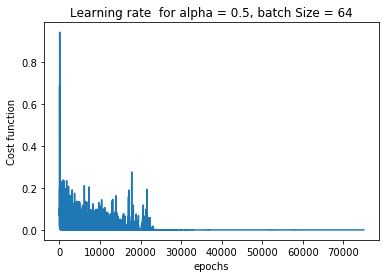

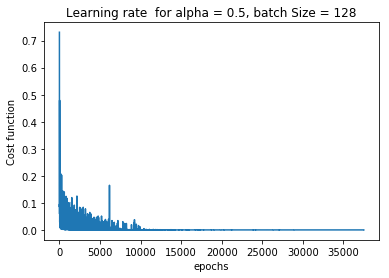

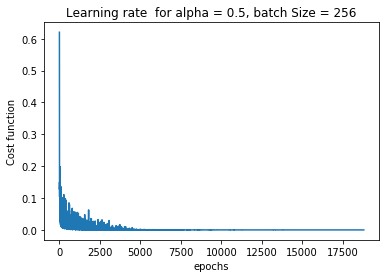

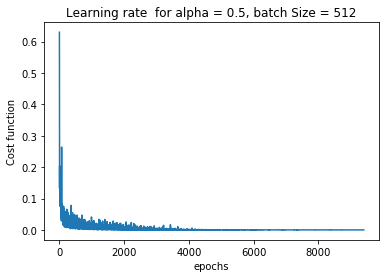

In [8]:
# alphas = [0.5]
alpha = 0.5
batchSizes = [64, 128, 256, 512]
best_cost = float('inf')
best_model = None
a = None
for batchSize in batchSizes:
    layers = 3
    neurons = [20, 10, 1]
    activations = ['ReLU', 'ReLU', 'sigmoid']
    DNN = DeepNeuralNetwork(x_train, y_train, x_test, y_test, alpha = alpha, layers = layers, neurons = neurons,
                           activations = activations, val = True, batchSize = batchSize)
    print('For batchSize = {}'.format(batchSize))
    W, b, A_f = DNN.miniBatchSGD(100)
    cost_val = DNN.Validate_model()
    if cost_val<best_cost:
        best_cost = cost_val
        best_model = DNN
        a = batchSize
print('Best validation cost = {}, achieved for batch size = {}'.format(best_cost, a))

# print('Batch Gradient descent:')
# W, b, A_f = DNN.train_model(100)
# cost_val = DNN.Validate_model()


### Discussion of the Minibatch SGD
It is evident from the learning curves, with increasing the batchsize, the learning curve becomes smoother, but the time required to converge also increases, althought the achieved accuracy on the training dataset and the validation set was almost similar (getting a little better with increase in the batch size). Based on the performance, it is evident that the batchsize of 256 gave the best performance both in terms of performance on the validation set and also faster convergence.

Thus, I have used the model with batch size = 256 for evaluation on the test data set.

Using the trained model with batch size = 256, the performance achived on the test set is as follows:

In [9]:
A_t1, A_t2 = best_model.test_model(x_test, y_test)

The cost on test set = 0.019016320067735643
The accuracy on test set = 0.9971


## Minibatch SGD with Momentum
Used the Minibatch SGD with momentum algorithm to train the neural network with 2 hidden layers consisting of 20 and 10 neurons respectively. ReLU is used as the activation function in the hidden layers, while sigmoid is used as the activation function in the output layers. The learning rate is set at 0.5 which was determined using cross validation. No regularization (either L2 or droput) was used while training the models. To investigate the impact of the momentum hyperparamter, different models were trained with varying momentums: (0.9, 0.99, 0.8, 0.6). The learning curve and the accuracy for all each of these models was determined and the best batch size was determined based on the performance on the validation set. The model with best performance on the validation set was then evaluated on the test set. 

For beta = 0.9


C:\Users\shrey\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:314: RuntimeWarning: divide by zero encountered in log
C:\Users\shrey\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:314: RuntimeWarning: invalid value encountered in multiply


Cost after Training =  2.551272257679961e-06
Accuracy on Training Data =  1.0
The cost on Validation set for alpha:0.5 = 0.01728319838030556
The accuracy on Validation set = 0.99775
For beta = 0.99
Cost after Training =  9.370084785698503e-05
Accuracy on Training Data =  0.9999791666666666
The cost on Validation set for alpha:0.5 = inf
The accuracy on Validation set = 0.99625
For beta = 0.8
Cost after Training =  3.0941477965411286e-06
Accuracy on Training Data =  1.0
The cost on Validation set for alpha:0.5 = 0.016608247953277304
The accuracy on Validation set = 0.9975
For beta = 0.6
Cost after Training =  2.7364431082869246e-06
Accuracy on Training Data =  1.0
The cost on Validation set for alpha:0.5 = 0.014487473180843124
The accuracy on Validation set = 0.9980833333333333
Best validation cost = 0.014487473180843124, achieved for beta = 0.6


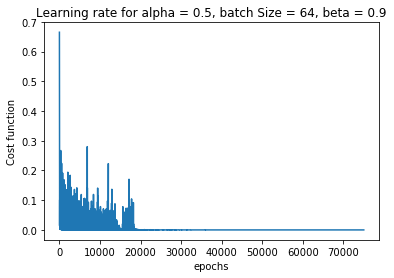

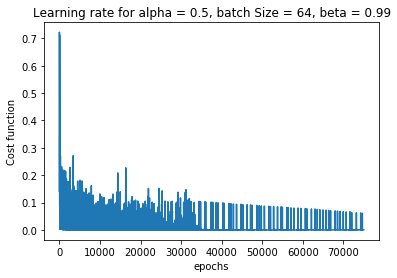

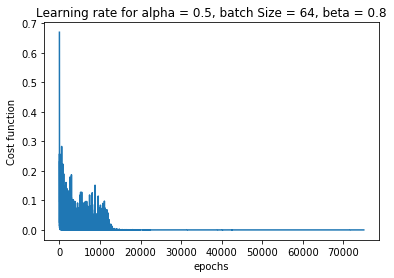

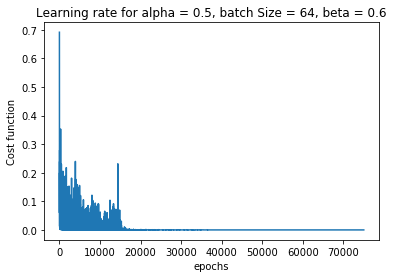

In [10]:
best_cost = float('inf')
best_model = None
a = None
betas = [0.9, 0.99, 0.8, 0.6]
for beta in betas:
    layers = 3
    neurons = [20, 10, 1]
    activations = ['ReLU', 'ReLU', 'sigmoid']
    DNN = DeepNeuralNetwork(x_train, y_train, x_test, y_test, alpha = alpha, layers = layers, neurons = neurons,
                           activations = activations, val = True, batchSize = 64, beta = beta)
    print('For beta = {}'.format(beta))
    W, b, A_f = DNN.MiniBatch_Momentum(100)
    cost_val = DNN.Validate_model()
    if cost_val<best_cost:
        best_cost = cost_val
        best_model = DNN
        a = beta
print('Best validation cost = {}, achieved for beta = {}'.format(best_cost, a))

### Discussion of the Minibatch SGD with Momentum
From the results on the validation set, the best performance was achived on the momentum hyperparameter value  = 0.6. Although the training accuracy and the validation accuracy were almost similar in all cases, the main difference was the learning curve and the time required for convergence. It was evident that with very high value of beta 0.99, learning curve was very spicky and the convergence time was high. While with decreasing values of beta, the learning curve became smoother and convergence time decreased in general. But for beta = 0.6 the smoothness of the learning curve decreased a little with increase in convergence time. 

The best model was evaluated on the test set and the following results were obtained:

In [11]:
A_t1, A_t2 = best_model.test_model(x_test, y_test)

The cost on test set = 0.01994498726243682
The accuracy on test set = 0.9977


C:\Users\shrey\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:314: RuntimeWarning: divide by zero encountered in log
C:\Users\shrey\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:314: RuntimeWarning: invalid value encountered in multiply
